In [245]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import math
import seaborn as sns
from sklearn.preprocessing import StandardScaler



data = pd.read_csv('data/GenreClassData_30s.txt', sep='\t')
data["TrackID"] = range(len(data))
# Split the data into training and testing sets
train = data[data['Type'] == 'Train']
test = data[data['Type'] == 'Test']

feature_columns = [col for col in data.columns if col not in ['Track ID','TrackID', 'File', 'GenreID', 'Genre', 'Type']]
# Define the features and targets
features = ['spectral_rolloff_mean', 'mfcc_1_mean', 'spectral_centroid_mean']
all_features = feature_columns
targets = ['Genre']

# feature data
X_train = train[features]
# genre data
y_train = train[targets]
X_test, y_test = test[features], test[targets]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # For training set
X_test_scaled = scaler.transform(X_test)  

In [246]:
# def eucledian_distance(sample_1, sample_2):
#     distance = 0
#     for i in range(len(sample_1)):
#        distance += (sample_1[i]-sample_2[i])**2
#     return np.sqrt(distance)


# # def get_feature_matrix(X_train, y_train):
# #     # Hent ut 'Genre' som første kolonne, deretter funksjonene
# #     genre_column = y_train  # Hent sjangerkolonnen
# #     feature_matrix = X_train  # Hent funksjonene som en numpy array
# #     feature_matrix_with_genre = np.hstack((genre_column.reshape(-1, 1), feature_matrix))  # Legg til sjanger som første kolonne
# #     return feature_matrix_with_genre


# def get_feature_matrix(X_train, y_train):
#     # Hent ut 'Genre' som første kolonne, deretter funksjonene
#     genre_column = y_train.values.reshape(-1, 1)  # Hent sjangerkolonnen og endre til kolonne
#     feature_matrix = X_train.values  # Hent funksjonene som en numpy array
#     feature_matrix_with_genre = np.hstack((genre_column, feature_matrix))  # Legg til sjanger som første kolonne
#     return feature_matrix_with_genre

# # print(get_feature_matrix(X_train,y_train))

# def compute_distances(feature_matrix, X_test_sample, k):
#     distances = []
#     for i in range(len(feature_matrix)):
#         distances.append((feature_matrix[i][0], eucledian_distance(feature_matrix[i][1:],X_test_sample)))

#     sorted_distances = sorted(distances, key=lambda x: x[1])
#     k_closest_labels = sorted_distances[0:k]

#     labels = [label for label, _ in k_closest_labels]
#     count = Counter(labels)
#     most_common_label = count.most_common(1)[0][0]
#     #return sorted_distances[0:k]
#     return most_common_label



# #print(compute_distances(get_feature_matrix(X_train,y_train), X_test.iloc[2], 5))


# def get_kNN(k, X_train, y_train, X_test):
#     feature_matrix = get_feature_matrix(X_train, y_train)

#     label_vector = []
#     for i in range(len(X_test)):
#         label_vector.append(compute_distances(feature_matrix, X_test.iloc[i], k))

#     return label_vector


# predicted_labels = get_kNN(5, X_train_scaled, y_train, X_test_scaled)



#test
def eucledian_distance(sample_1, sample_2):
    distance = 0
    for i in range(len(sample_1)):
        distance += (sample_1[i] - sample_2[i]) ** 2
    return np.sqrt(distance)

# Get feature matrix including genre column
def get_feature_matrix(X_train_array, y_train_df):
    # y_train_df is a pandas DataFrame with shape (n, 1)
    genre_column = y_train_df.values.reshape(-1, 1)  # Convert to Nx1 numpy array
    # X_train_array is already a numpy array from StandardScaler
    feature_matrix_with_genre = np.hstack((genre_column, X_train_array))
    return feature_matrix_with_genre
# Compute distances and find k nearest neighbors
def compute_distances(feature_matrix, X_test_sample, k):
    distances = []
    for i in range(len(feature_matrix)):
        distance = eucledian_distance(feature_matrix[i][1:], X_test_sample)  # Ignore genre column
        distances.append((feature_matrix[i][0], distance))  # Append genre and distance

    sorted_distances = sorted(distances, key=lambda x: x[1])  # Sort by distance
    k_closest_labels = sorted_distances[:k]

    labels = [label for label, _ in k_closest_labels]  # Extract the k closest labels
    count = Counter(labels)
    most_common_label = count.most_common(1)[0][0]
    return most_common_label

# Get k-NN predictions for the entire test set
def get_kNN(k, X_train_array, y_train_df, X_test_array):
    feature_matrix = get_feature_matrix(X_train_array, y_train_df)
    label_vector = []

    # X_test_array is a NumPy array, so we use X_test_array[i]
    for i in range(len(X_test_array)):
        label_vector.append(compute_distances(feature_matrix, X_test_array[i], k))

    return label_vector

# Get the predictions for the test set
predicted_labels = get_kNN(5, X_train_scaled, y_train, X_test_scaled)


    


In [ ]:
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0






def knn_feature_selection(candidate_features, current_features, train, test, y_train, y_test, k=5): ##Idiotisk funksjon som sjekker alle features opp mot de som er i features og returnere den som gir best accuracy 
    best_accuracy = 0
    best_feature = None
    # Iterate over each candidate that is not already selected
    for candidate in candidate_features:
        # Form a new feature set: current_features + candidate
        new_features = current_features + [candidate]
        print(f"Testing features: {new_features}")
        
        # Extract these features for training and testing
        X_train_candidate = train[new_features]
        X_test_candidate = test[new_features]
        
        # Scale these feature sets
        scaler = StandardScaler()
        X_train_scaled_candidate = scaler.fit_transform(X_train_candidate)
        X_test_scaled_candidate = scaler.transform(X_test_candidate)
        
        # Run k-NN with the current candidate feature set
        predicted = get_kNN(k, X_train_scaled_candidate, y_train, X_test_scaled_candidate)
        # Convert actual y_test to a 1D array
        y_true = y_test.values.flatten()
        acc = accuracy_metric(y_true, predicted)
        print(f"Candidate feature '{candidate}' produced accuracy: {acc:.2f}%")
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_feature = candidate
        new_features = np.delete(new_features,len(new_features)-1)

    print("\nBest candidate feature:", best_feature, "with accuracy:", best_accuracy)
    return best_feature, best_accuracy
candidate_features = [f for f in feature_columns if f not in features]
print(knn_feature_selection(candidate_features,features,train,test,y_train,y_test, k=5))

Testing features: ['spectral_rolloff_mean', 'mfcc_1_mean', 'spectral_centroid_mean', 'zero_cross_rate_mean']
Candidate feature 'zero_cross_rate_mean' produced accuracy: 46.97%
Testing features: ['spectral_rolloff_mean', 'mfcc_1_mean', 'spectral_centroid_mean', 'zero_cross_rate_std']
Candidate feature 'zero_cross_rate_std' produced accuracy: 42.93%
Testing features: ['spectral_rolloff_mean', 'mfcc_1_mean', 'spectral_centroid_mean', 'rmse_mean']
Candidate feature 'rmse_mean' produced accuracy: 45.96%
Testing features: ['spectral_rolloff_mean', 'mfcc_1_mean', 'spectral_centroid_mean', 'rmse_var']
Candidate feature 'rmse_var' produced accuracy: 48.48%
Testing features: ['spectral_rolloff_mean', 'mfcc_1_mean', 'spectral_centroid_mean', 'spectral_centroid_var']
Candidate feature 'spectral_centroid_var' produced accuracy: 39.39%
Testing features: ['spectral_rolloff_mean', 'mfcc_1_mean', 'spectral_centroid_mean', 'spectral_bandwidth_mean']
Candidate feature 'spectral_bandwidth_mean' produced a

In [248]:
accuracy_metric(y_test.values.flatten(), predicted_labels)

38.88888888888889

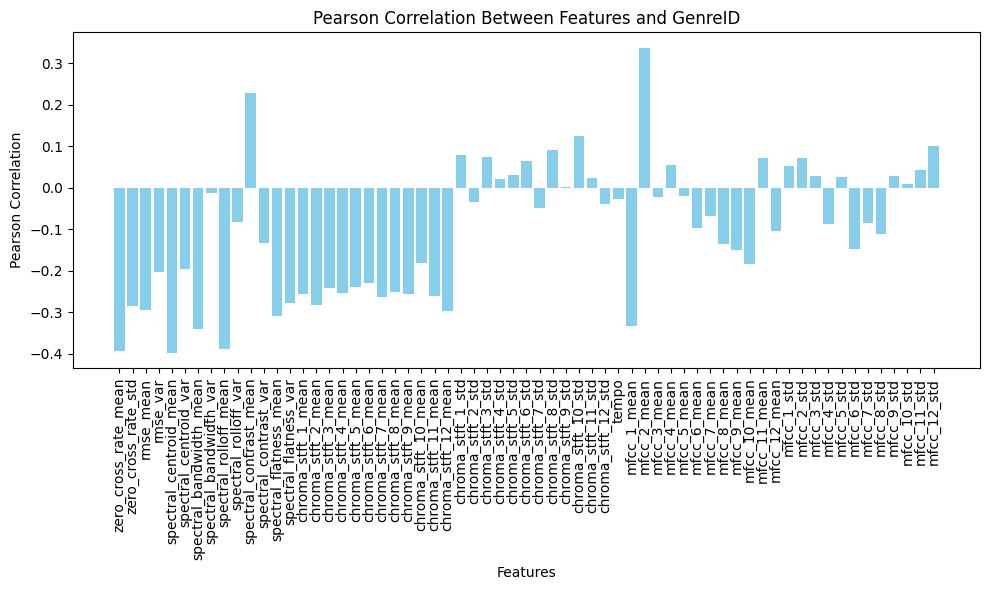

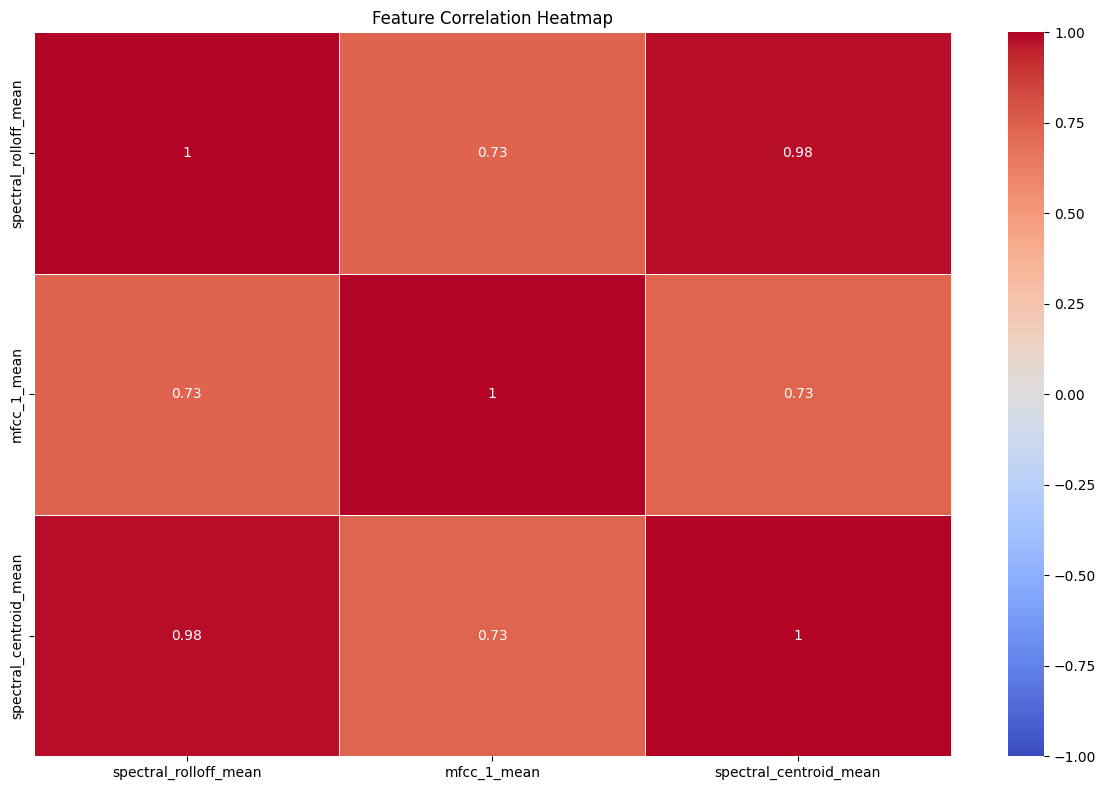

In [249]:
# def covariance(X_test,y_test):
# print(X_test)

def sample_mean(data):
    my = 0
    for i in range(len(data)):
        my += data[i]
    return my/len(data)




def cov(x_data, y_data):
    cov = 0
    x_mean = sample_mean(x_data)
    y_mean = sample_mean(y_data)



    for i in range(len(x_data)):
        cov += (x_data[i]-x_mean)*(y_data[i]-y_mean)
    return cov



def pearson_correlation(x_data, y_data):
    sigX = 0
    sigY = 0
    x_data_mean = sample_mean(x_data)
    y_data_mean = sample_mean(y_data)
    
    for i in range(len(x_data)):
        sigX += (x_data[i] - x_data_mean)**2
        sigY += (y_data[i] - y_data_mean)**2

    return cov(x_data, y_data)/math.sqrt(sigX*sigY)


# def get_feature_correlation_matrix(features, train_data):
#     corr_matrix = []
#     for i in range(len(features)):
#         row = []
#         f_i = train_data[features[i]]
#         for j in range(len(features)):
#             f_j = train_data[features[j]]
#             row.append(pearson_correlation(f_i,f_j))
#         corr_matrix.append(row)
#     return corr_matrix

def get_feature_correlation_matrix(features, train_data):
    corr_matrix = train_data[features].corr()  # Use pandas .corr() for efficient computation
    return corr_matrix


def p_corr_features(features, y_data, train_data):
    p_vec = []
    for i in range(len(features)):
        x = train_data[features[i]]
        p = pearson_correlation(x,y_data)
        p_vec.append(p)
    
    return p_vec

# X_train_test = X_train[features[3]]
genre_id = train["GenreID"]


corr= p_corr_features(all_features, genre_id, train)

corr_matrix = get_feature_correlation_matrix(features, train)
# print(corr_matrix)

plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.bar(all_features, corr, color='skyblue')  # Bar chart
plt.xlabel('Features')  # Label for the x-axis
plt.ylabel('Pearson Correlation')  # Label for the y-axis
plt.title('Pearson Correlation Between Features and GenreID')  # Title
plt.xticks(rotation=90)  # Rotate feature names if they are long
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()



# Assuming 'corr_matrix' is the pandas DataFrame that holds the correlation matrix
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))  # Adjust the size of the plot for better readability
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

plt.title('Feature Correlation Heatmap')  # Title of the heatmap
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

**Korrelasjonsmatrise mellom features (heatmap) og korrelasjon mellom feature og output over**
Testet litt forskjellig og kom frem til at det var best å droppe 'tempo' da denne både har lav korrelasjon med output (0.025) og har lav varians. Det kan argumenteres for å også droppe 'spectral_centroid_mean' da denne har korrelerer svært med 'spectral_rolloff_mean' (0.98). Ideelt sett skulle vi ha droppet både denne og tempo.

Videre er et forsøk på å finne den neste featuren ved å finne en feature som både korrelerer godt med output og lite med de andre featuresene. Her har jeg forsøkt å hente ut de featuresene som korrelerer mest med output og lagret de i most_correlated. Deretter har jeg plottet disse i et heatmap med de allerede valgte featuresene. Utifra dette kom jeg frem til at zero_cross_rate_mean ga best resultat. da den har god p-korrelasjon og korrelerer bare delvis med de andre featuresene. 

Jeg skalerte også X_train og X_test da resultatet nesten ikke endret seg hadde jeg ikke skalert (skjønte ikke helt hvorfor, men chatten sa det... Tror det er fordi en av featurene dominerer altfor mye til at de andre har noe å si. Tipper dette kan være spectral_roloff_mean da den hadde svært stor varians.)



[[np.float64(0.3973420835367922), 'spectral_centroid_mean'], [np.float64(0.3926118275167823), 'zero_cross_rate_mean'], [np.float64(0.3879558762188767), 'spectral_bandwidth_mean'], [np.float64(0.3398394587209239), 'spectral_centroid_mean'], [np.float64(0.33744646038668513), 'chroma_stft_11_std'], [np.float64(0.33382843723044436), 'chroma_stft_10_std'], [np.float64(0.3100858232491277), 'spectral_rolloff_mean']]


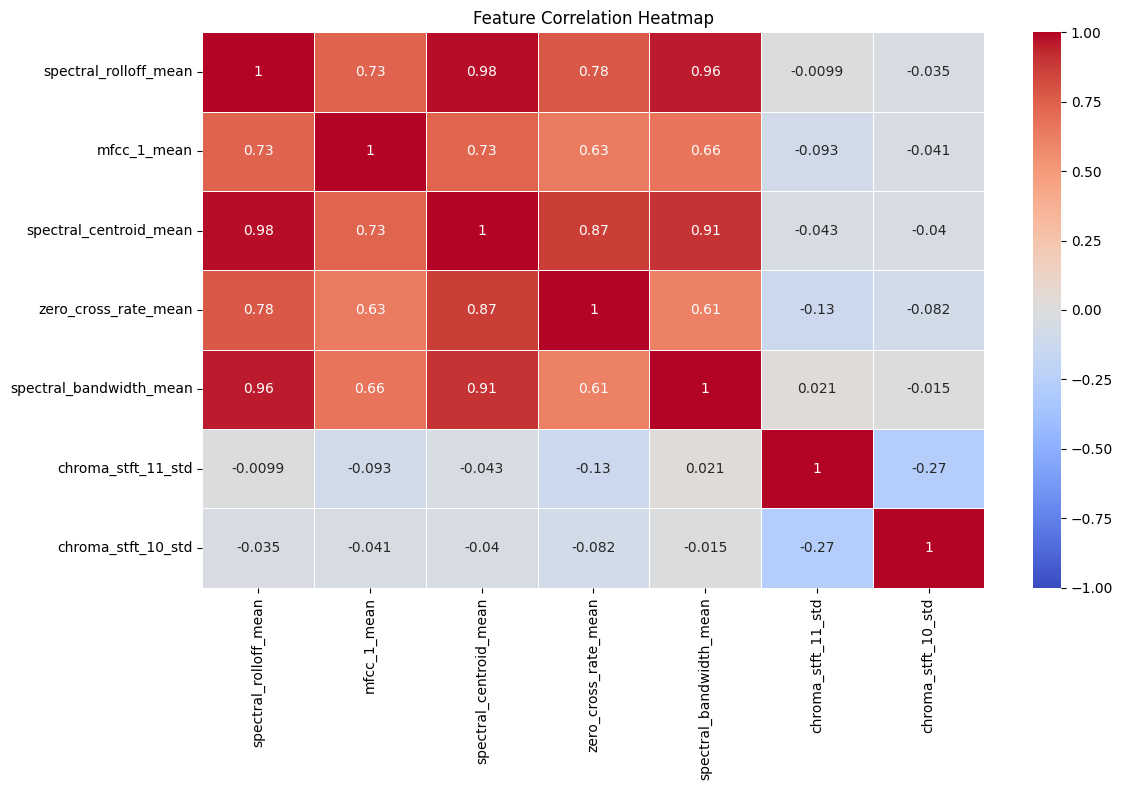

In [250]:
##find next feature.

corr_y = np.abs(p_corr_features(all_features, genre_id, train))

most_correlated = [] #de 7 featuresene som korrelerer mest med output

for i in range(7):
    mostly_correlated = np.argmax(corr_y)
    feat = all_features[mostly_correlated]
    most_correlated.append([np.max(corr_y), feat])


    corr_y = np.delete(corr_y,mostly_correlated)
features_test = features
for i in range(len(most_correlated)):
    if(most_correlated[i][1] not in features):
        features_test.append(most_correlated[i][1])

print(most_correlated)

corr_test = get_feature_correlation_matrix(features_test, train)



plt.figure(figsize=(12, 8))  # Adjust the size of the plot for better readability
sns.heatmap(corr_test, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

plt.title('Feature Correlation Heatmap')  # Title of the heatmap
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()




In [251]:


# print predicted_labels and y_test together in a table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(pd.DataFrame({'Predicted': predicted_labels, 'True': y_test.values.ravel()}))

     Predicted       True
0          pop        pop
1        metal        pop
2       reggae        pop
3          pop        pop
4          pop        pop
5         rock        pop
6      country        pop
7          pop        pop
8          pop        pop
9        disco        pop
10         pop        pop
11         pop        pop
12         pop        pop
13      reggae        pop
14         pop        pop
15         pop        pop
16         pop        pop
17       blues        pop
18         pop        pop
19       disco        pop
20       metal      metal
21       metal      metal
22       metal      metal
23       metal      metal
24      reggae      metal
25       metal      metal
26      reggae      metal
27       disco      metal
28       metal      metal
29       metal      metal
30       metal      metal
31        rock      metal
32      reggae      metal
33       metal      metal
34       metal      metal
35       metal      metal
36       metal      metal
37       met